In [ ]:
%pip install --upgrade pandas
%pip install --upgarde matplotlib

<Axes: xlabel='name'>

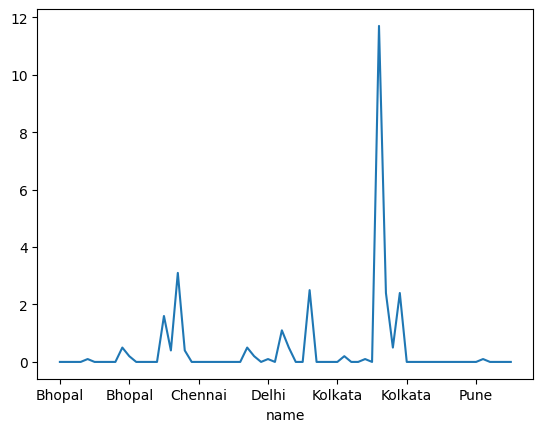

In [39]:
core_weather["precip"].plot()